In [2]:
import seaborn as sns
from queries import*
from utilities import*

## Importing Data

In [26]:
PATIENT_ID = '1Y1'
INPUT_PATH = './data/input/DEEPMEL_' + PATIENT_ID + '/'
OUTPUT_PATH = './data/output/DEEPMEL_' + PATIENT_ID +'/'
PLOT_PATH ='./plots/DEEPMEL_' + PATIENT_ID +'/'
INPUT_FILE = 'DEEPMEL_'+ PATIENT_ID +'_cell_seg_data.csv'
TABLE_NAME_BQ = 'DEEPMEL_'+ PATIENT_ID +'_cell_seg_data'
HIGH_VOLUME = False

In [27]:
HIGH_VOLUME

False

In [28]:
cell_data = pd.read_csv(INPUT_PATH  + INPUT_FILE)

In [29]:
cell_data.head(3)

,cell_id,cell_x_position,cell_y_position,tissue_category,phenotype
0,11477,17511.0,37637.3,stroma,DAPIp
1,11478,16949.9,37640.2,stroma,DAPIp
2,11480,17139.9,37643.7,stroma,DAPIp


In [30]:
cell_data['phenotype'] = cell_data['phenotype'].apply(lambda x: get_phenotype(x))

## EDA

In [31]:
len(cell_data)

177953

In [32]:
cell_data.tissue_category.unique()

array(['stroma', 'missing', 'tumor'], dtype=object)

In [33]:
cell_data.phenotype.value_counts()

tumor          99150
T              36820
stroma         32441
MISSING         5874
macrophages     3023
B                586
NK                59
Name: phenotype, dtype: int64

In [34]:
cell_data.tissue_category.value_counts()

tumor      129676
stroma      48056
missing       221
Name: tissue_category, dtype: int64

<AxesSubplot:xlabel='cell_x_position', ylabel='cell_y_position'>

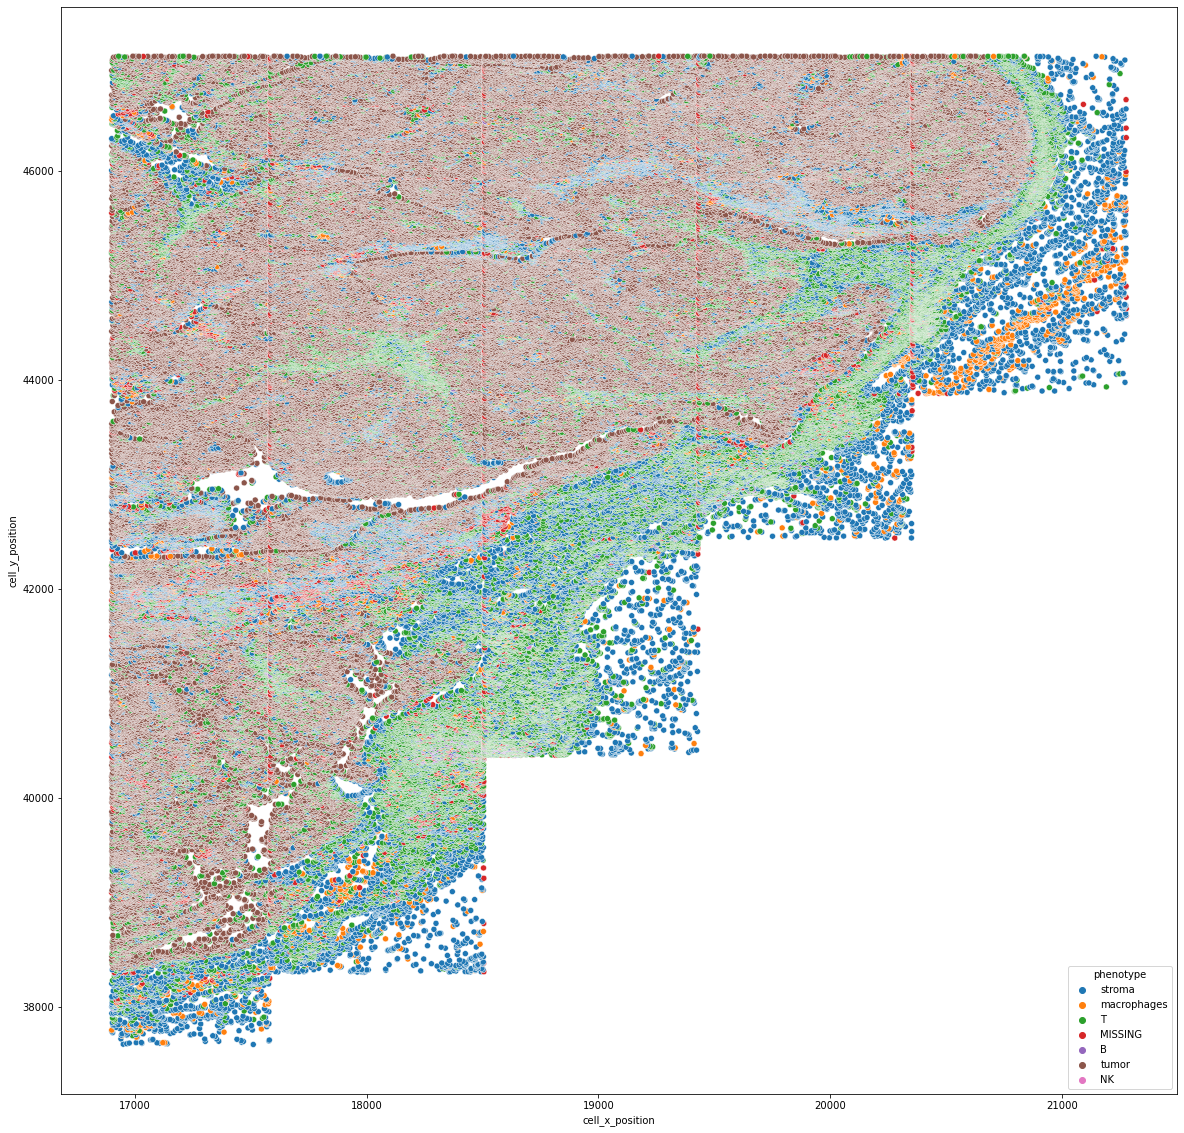

In [35]:
fig, ax = plt.subplots(figsize = (20,20))
sns.scatterplot(data = cell_data , x='cell_x_position', y= 'cell_y_position', hue = 'phenotype',
                cmap =sns.color_palette("tab10"))

In [36]:
columns_to_keep = ['cell_id','cell_x_position','cell_y_position','tissue_category']
cell_data_restricted = cell_data[columns_to_keep]

## Computing pairwise distances

### Compute pairwise distances

In [37]:
UNIQUE_ID = cell_data_restricted.cell_id.unique()
N_CELL = len(cell_data_restricted.cell_id.unique())
N_REPARTITION = 30
repartition =[int(x) for x in np.linspace(0,N_CELL,N_REPARTITION)]

## All pairwise distances

In [38]:
def set_query(lower_bound_tab_1 =0, upper_bound_tab_1 = 1000, lower_bound_table_2 =0):
    
    query = '''SELECT
  distance,
  cell_id_1,
  cell_id_2
  tissue_category_1,
  tissue_category_2
FROM (
  SELECT
    table_1.cell_id_1,
    table_2.cell_id_2,
    table_1.x_1,
    table_1.y_1,
    table_2.x_2,
    table_2.y_2,
    tissue_category_1,
    tissue_category_2 ,

    SQRT(POW((x_1-x_2),2)+POWER((y_1-y_2),2)) AS distance
  FROM (
    SELECT
      cell_x_position AS x_1,
      cell_y_position AS y_1,
      cell_id AS cell_id_1,
      tissue_category as tissue_category_1
    FROM
      `advance-sonar-306410.deepmelo.cell_data`
      Where (cell_id>{lower1}) and  (cell_id<={upper1}) ) AS table_1
  CROSS JOIN (
    SELECT
      cell_x_position AS x_2,
      cell_y_position AS y_2,
      cell_id AS cell_id_2,
      tissue_category as tissue_category_2
    FROM
      `advance-sonar-306410.deepmelo.cell_data` 
      Where (cell_id>{lower2})) AS table_2 )'''.format(lower1=lower_bound_tab_1,upper1=upper_bound_tab_1,lower2=lower_bound_table_2)
    
    return query

In [8]:
def set_query_coordinates(patient_id, x_lower =0, x_upper = 1000, y_lower=0, y_upper=1000, thrd =0):

    query =  '''SELECT
    distance,
    cell_id_1,
    cell_id_2,
    tissue_category_1,
     tissue_category_2,
     phenotype_1,
  phenotype_2,
 FROM (
  SELECT
    table_1.cell_id_1,
    table_2.cell_id_2,
    table_1.x_1,
    table_1.y_1,
    table_2.x_2,
    table_2.y_2,
    tissue_category_1,
    tissue_category_2,
    phenotype_1,
    phenotype_2,


    SQRT(POW((x_1-x_2),2)+POWER((y_1-y_2),2)) AS distance
  FROM (
    SELECT
      cell_x_position AS x_1,
      cell_y_position AS y_1,
      cell_id AS cell_id_1,
      tissue_category as tissue_category_1,
      phenotype as phenotype_1
    FROM
      `advance-sonar-306410.deepmelo.DEEPMEL_{patient_id}_cell_seg_data`
      Where ((cell_x_position>{x_lower_1} and cell_x_position<{x_upper_1})and (cell_y_position>{y_lower_1} and cell_y_position<{y_upper_1})) ) AS table_1
  CROSS JOIN (
    SELECT
      cell_x_position AS x_2,
      cell_y_position AS y_2,
      cell_id AS cell_id_2,
      tissue_category as tissue_category_2,
      phenotype as phenotype_2,
 
    FROM
      `advance-sonar-306410.deepmelo.DEEPMEL_1C1_cell_seg_data` 
      Where ((cell_x_position>{x_lower_2} and cell_x_position<{x_upper_2})and (cell_y_position>{y_lower_2} and cell_y_position<{y_upper_2}))) AS table_2 )

    where distance < {thrd} and (cell_id_1 < cell_id_2)'''.format(patient_id =patient_id,
                                                                  x_lower_1= x_lower,
                                                                  x_upper_1= x_upper,
                                                                  y_lower_1=y_lower,
                                                                  y_upper_1 = y_upper,
                                                                  x_lower_2= x_lower,
                                                                  x_upper_2=x_upper,
                                                                  y_lower_2=y_lower,
                                                                  y_upper_2 = y_upper,
                                                                  thrd = thrd)

    return query




## Bipartite graph query

In [39]:
def pairwise_distance_threshold(table, upper_thrd =100):
    
    query = '''SELECT
  distance,
  cell_id_1,
  cell_id_2,
  tissue_category_1,
  tissue_category_2
FROM (
  SELECT
    table_1.cell_id_1,
    table_2.cell_id_2,
    table_1.x_1,
    table_1.y_1,
    table_2.x_2,
    table_2.y_2,
    tissue_category_1,
    tissue_category_2 ,

    SQRT(POW((x_1-x_2),2)+POWER((y_1-y_2),2)) AS distance
  FROM (
    SELECT
      cell_x_position AS x_1,
      cell_y_position AS y_1,
      cell_id AS cell_id_1,
      tissue_category as tissue_category_1
    FROM
      `advance-sonar-306410.deepmelo.{table}`
      Where (tissue_category = 'stroma' )) AS table_1
  CROSS JOIN (
    SELECT
      cell_x_position AS x_2,
      cell_y_position AS y_2,
      cell_id AS cell_id_2,
      tissue_category as tissue_category_2
    FROM
      `advance-sonar-306410.deepmelo.{table}` 
      Where (tissue_category = 'tumor')) AS table_2 )

Where distance<{upper} '''.format(table=table,upper=upper_thrd)
    
    return query
    
    

## Extracting statistics from pairwise distances

### Defining a function running queries on Bigquery

In [40]:
def run_bq(query,query_name,return_df_csv = True):
    client = bigquery.Client() 
    query_job = client.query(query)
    if return_df_csv:
        df = query_job.result().to_dataframe()
        df.to_csv(OUTPUT_PATH+ query_name+ '.csv', index =False)
        print("Query results loaded to the table {} on VM".format(query_name))
        #return df
   

### Defining query names

In [41]:
def set_query_parameters(query_name,table_bq, use_threshold =False, thrd=100):
    if use_threshold:
        return queries[query_name].format(table=table_bq, thrd = thrd)
    else :
        return queries[query_name].format(table=table_bq)

In [42]:
### Queries names

BIPARTITE_QUERY = set_query_parameters('bipartite_tumor_stroma',TABLE_NAME_BQ,True,200)
STATISTICS_STROMA = set_query_parameters('distance_statistics_to_stroma',TABLE_NAME_BQ)
STATISTICS_TUMOR = set_query_parameters('distance_statistics_to_tumor',TABLE_NAME_BQ)
STATISTICS_ALL_CELL = set_query_parameters('distance_statistics_all_cells',TABLE_NAME_BQ)

### Running distance statistics queries

In [43]:
##statistics queries 

#statistics_all_cells = run_bq(STATISTICS_ALL_CELL,'distance_statistics_all_cells')
#statistics_tumor = run_bq(STATISTICS_TUMOR,'distance_statistics_to_tumor')
#statistics_stroma = run_bq(STATISTICS_STROMA,'distance_statistics_to_stroma')

In [44]:
#statistics_all_cells = run_bq(BIPARTITE_QUERY,'distance_statistics_all_cells')

# Running bipartite Stroma vs Tumor

### For high volume data we run the bipartite_tumor_stroma query rather than running the pairwise distances_thrd_query

we will define a high_volume variable: HIGH_VOLUME

Fix a distance thereshold first that will determine the relational data base, we consider theresholds 20, 50, 80, 100, 200

### Getting pairwise distances by fixing cell_id lower and upper bounds

In [45]:
#thrd_list = [100,150,200]
#for thrd in thrd_list :
#    table_name = 'pairwise_distances_thrd_{}'.format(thrd)
#    client = bigquery.Client()
#    query = pairwise_distance_threshold(TABLE_NAME_BQ,thrd)
#    df = client.query(query).to_dataframe()
#    print('Dataframe with threshold {} extracted'.format(thrd))
#    df.to_csv(OUTPUT_PATH +table_name + '.csv', index = False)

## Extracting edges with distance threshold 50

### Defining query

In [46]:
def query_distance_threshold(table_bq ,thrd=50):
    
    query = '''SELECT
    distance,
    cell_id_1,
  cell_id_2,
  tissue_category_1,
  tissue_category_2,
  phenotype_1,
  phenotype_2,
FROM (
  SELECT
    table_1.cell_id_1,
    table_2.cell_id_2,
    table_1.x_1,
    table_1.y_1,
    table_2.x_2,
    table_2.y_2,
    tissue_category_1,
    tissue_category_2 ,
    phenotype_1,
    phenotype_2,
    SQRT(POWER((x_1-x_2),2)+POWER((y_1-y_2),2)) AS distance
    
  FROM (
    SELECT
      cell_x_position AS x_1,
      cell_y_position AS y_1,
      cell_id AS cell_id_1,
      tissue_category as tissue_category_1,
      phenotype as phenotype_1

    FROM
      `advance-sonar-306410.deepmelo.{table}`
       ) AS table_1
  CROSS JOIN (
    SELECT
      cell_x_position AS x_2,
      cell_y_position AS y_2,
      cell_id AS cell_id_2,
      tissue_category as tissue_category_2,
      phenotype as phenotype_2,

    FROM
      `advance-sonar-306410.deepmelo.{table}` 
      ) AS table_2 )

 where distance < {thrd} and (cell_id_1 < cell_id_2)
      '''.format(table=table_bq,thrd=thrd)
    return query

In [47]:
def get_edges(HIGH_VOLUME=False,THRESHOLD=100):
    
    table_name = 'edges_thrd_{}'.format(THRESHOLD)

    if HIGH_VOLUME:
        query = set_query_parameters('bipartite_tumor_stroma',TABLE_NAME_BQ,True,THRESHOLD)
    else:
        query = query_distance_threshold(TABLE_NAME_BQ,THRESHOLD)
        
    client = bigquery.Client()    
    df = client.query(query).to_dataframe()
    print('Dataframe with threshold {} extracted'.format(THRESHOLD))
    df.to_csv(OUTPUT_PATH +table_name + '.csv', index = False)
    
    return df 

In [76]:
THRESHOLD = 20
#edge_data = get_edges(HIGH_VOLUME,THRESHOLD)

In [ ]:
#THRSHOLD = 20
#table_name = 'edges_thrd_{}'.format(THRSHOLD)
#client = bigquery.Client()
#query = query_distance_threshold(TABLE_NAME_BQ,THRSHOLD)
#df = client.query(query).to_dataframe()
#print('Dataframe with threshold {} extracted'.format(THRSHOLD))
#df.to_csv(OUTPUT_PATH +table_name + '.csv', index = False)

# Stepwise querying 

In [46]:
PATIENT_ID = '1C1'
INPUT_PATH = './data/input/DEEPMEL_' + PATIENT_ID + '/'
OUTPUT_PATH = './data/output/DEEPMEL_' + PATIENT_ID +'/'
PLOT_PATH ='./plots/DEEPMEL_' + PATIENT_ID +'/'
INPUT_FILE = 'DEEPMEL_'+ PATIENT_ID +'_cell_seg_data.csv'
TABLE_NAME_BQ = 'DEEPMEL_'+ PATIENT_ID +'_cell_seg_data'
HIGH_VOLUME = False

In [47]:
cell_data = pd.read_csv(INPUT_PATH  + INPUT_FILE)

In [48]:
N = len(cell_data)
r = int((N/1000)/200)+1
q = np.linspace(0, 1, r+2)

x_values = cell_data.cell_x_position.values
y_values = cell_data.cell_y_position.values

x_thrd = np.quantile(x_values, q)
y_thrd = np.quantile(y_values, q)

EPSILONE =50


In [49]:
y_thrd

array([37381.9, 38695.8, 39457.9])

In [50]:
x_thrd

array([12122.5, 15602.1, 19508.4])

In [51]:
n = len(x_thrd)
edges = pd.DataFrame({}) 

for index in range(n)[1:]:
    x0 = x_thrd[index-1]-EPSILONE
    x1 = x_thrd[index]+EPSILONE
    for index in range(n)[1:]:
        y0 = y_thrd[index-1]-EPSILONE
        y1 = y_thrd[index]+EPSILONE

        query = set_query_coordinates(PATIENT_ID, x_lower =x0, x_upper = x1, y_lower=y0, y_upper=y1, thrd =100)
        client = bigquery.Client()    
        df = client.query(query).to_dataframe()
        edges = pd.concat([edges,df])
        edges = edges.drop_duplicates(['cell_id_1','cell_id_2'])

edges.to_csv(OUTPUT_PATH+'edges.csv', index = False)
    
    
    
    

NameError: name 'set_query_coordinates' is not defined

In [13]:
edges.head()

,distance,cell_id_1,cell_id_2,tissue_category_1,tissue_category_2,phenotype_1,phenotype_2
0,98.419917,44154,50056,tumor,tumor,CD3p,SOX10p
1,63.837606,44154,44334,tumor,tumor,CD3p,SOX10p
2,64.114039,44154,44235,tumor,tumor,CD3p,SOX10p
3,70.799011,44154,50406,tumor,tumor,CD3p,MISSING
4,77.540248,47622,48174,stroma,tumor,CD3p,SOX10p


In [6]:
edges = pd.read_csv(OUTPUT_PATH+'edges.csv')

In [22]:
edges_data = graph_wrangling(edges, 15, False)
edges_data['phenotype_1'] = edges_data['phenotype_1'].apply(lambda x: get_phenotype(x))
edges_data['phenotype_2'] = edges_data['phenotype_2'].apply(lambda x: get_phenotype(x))

In [23]:
import plotly.graph_objects as go

In [24]:
cells = cell_data[['cell_id','cell_x_position','cell_y_position']]

In [25]:
edges_with_position = edges_data.merge(cells, left_on = 'cell_id_1', right_on='cell_id', how='outer')

In [26]:
edges_with_position = edges_with_position.merge(cells, left_on = 'cell_id_2', right_on='cell_id', how='outer')

In [27]:
edges_with_position.head()

,distance,cell_id_1,cell_id_2,tissue_category_1,tissue_category_2,phenotype_1,phenotype_2,cell_id_x,cell_x_position_x,cell_y_position_x,cell_id_y,cell_x_position_y,cell_y_position_y
0,14.912076,20675.0,20790.0,tumor,tumor,stroma,stroma,20675.0,14999.2,38717.1,20790.0,14993.8,38731.0
1,12.404032,20765.0,20790.0,tumor,tumor,tumor,stroma,20765.0,14981.9,38727.5,20790.0,14993.8,38731.0
2,9.542536,20741.0,20790.0,tumor,tumor,tumor,stroma,20741.0,14986.3,38725.1,20790.0,14993.8,38731.0
3,6.419502,20734.0,20790.0,stroma,tumor,stroma,stroma,20734.0,14993.3,38724.6,20790.0,14993.8,38731.0
4,13.559499,20678.0,20790.0,tumor,tumor,tumor,stroma,20678.0,14987.3,38719.1,20790.0,14993.8,38731.0


In [28]:
cell_data['phenotype'] = cell_data['phenotype'].apply(lambda x: get_phenotype(x))

In [29]:
def cut_cercular_region(nodes, center=[0,0], diameter = 100):
    
    nodes_x_coordinates = nodes.cell_x_position.values
    nodes_y_coordinates = nodes.cell_y_position.values
    nodes_id = nodes.cell_id.values
    
    in_cercle_nodes = []
    points = []
    
    for cell_id,x,y in zip(nodes_id,nodes_x_coordinates,nodes_y_coordinates):
        
        if np.sqrt(np.power((x-center[0]),2) + np.power((y-center[1]),2) ) < diameter :
            
            in_cercle_nodes.append(cell_id)
            points.append([x,y])
            
    return in_cercle_nodes, points

In [30]:
center_id = 44454
center_x  = float(cell_data[cell_data.cell_id == center_id].cell_x_position.values)
center_y  = float(cell_data[cell_data.cell_id == center_id].cell_y_position.values)

In [31]:
cercle, points = cut_cercular_region(cell_data, center=[center_x,center_y], diameter = 100)

In [32]:
edges_in_cercle = edges_with_position[edges_with_position.apply(lambda x : (x.cell_id_1  in cercle) | (x.cell_id_2  in cercle), axis = 1) ]

In [33]:
edges_in_cercle

,distance,cell_id_1,cell_id_2,tissue_category_1,tissue_category_2,phenotype_1,phenotype_2,cell_id_x,cell_x_position_x,cell_y_position_x,cell_id_y,cell_x_position_y,cell_y_position_y
657,12.522779,44624.0,44676.0,stroma,stroma,stroma,stroma,44624.0,14192.5,39008.9,44676.0,14204.4,39012.8
658,10.322790,44598.0,44676.0,stroma,stroma,T,stroma,44598.0,14198.4,39004.4,44676.0,14204.4,39012.8
933,12.256019,44302.0,44401.0,tumor,tumor,tumor,tumor,44302.0,14280.3,38971.7,44401.0,14284.8,38983.1
934,13.060245,44317.0,44401.0,tumor,tumor,stroma,tumor,44317.0,14292.7,38972.7,44401.0,14284.8,38983.1
935,13.140015,44379.0,44401.0,tumor,tumor,stroma,tumor,44379.0,14297.7,38980.6,44401.0,14284.8,38983.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58300,8.823831,45294.0,45330.0,stroma,tumor,stroma,stroma,45294.0,14214.8,39082.8,45330.0,14207.9,39088.3
58307,7.640026,44650.0,44699.0,stroma,stroma,stroma,stroma,44650.0,14221.3,39009.9,44699.0,14223.2,39017.3
58385,7.433034,44827.0,44902.0,tumor,tumor,tumor,tumor,44827.0,14246.6,39032.2,44902.0,14241.1,39037.2
58429,4.517743,44214.0,44215.0,stroma,stroma,stroma,stroma,44214.0,14239.1,38959.8,44215.0,14243.6,38960.2


In [37]:
cell_data_Res = cell_data[cell_data.cell_id.apply(lambda x: x in cercle)]

In [38]:
edge_x = []
edge_y = []
for idx, row in edges_in_cercle.iterrows():
    
    cell_1 = row.cell_id_1
    cell_2 = row.cell_id_2
    
    x0 = row.cell_x_position_x
    y0 = row.cell_y_position_x
    
    
    x1 = row.cell_x_position_y
    y1 = row.cell_y_position_y
    

    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
colors = []
phenotypes = []
color_mapping = {'tumor':'darkred', 'stroma':'peru',
                 'T':'springgreen', 'B':'turquoise','macrophages':'khaki',
                 'dendtritic':'orange', 'NK':'gray', 'MISSING' :'slategray'}  

for idx,node in cell_data_Res.iterrows():
    
    x = float(node.cell_x_position)
    y = float(node.cell_y_position)
    phenotype = node.phenotype
    color = color_mapping[phenotype]
    node_x.append(x)
    node_y.append(y)
    colors.append(color)
    phenotypes.append(phenotype)
    
    


    
    
                     
                     
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color= [],
        size=10,
        colorbar=dict(
            thickness=10,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

node_trace.marker.color = colors
node_trace.text = phenotypes


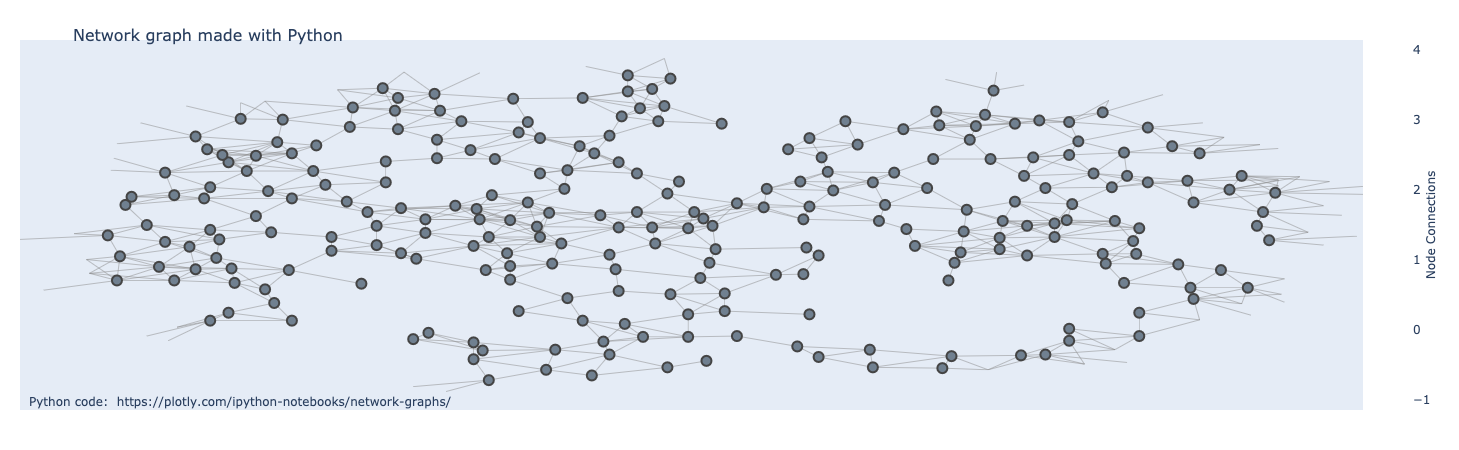

In [39]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=40,l=20,r=40,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                width = 304,
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)) )
fig.show()